In [1]:
pip install xgboost

     |████████████████████████████████| 173.6 MB 6.1 kB/s              ████▎                    | 61.1 MB 30.4 MB/s eta 0:00:04��████████████████████████████▉  | 161.7 MB 107.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [11]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 50)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

## Defining the bucket 
s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

## Defining the csv file 
file_key_train = 'Forecasting-Flow-Traffic/train.csv'
file_key_test = 'Forecasting-Flow-Traffic/test.csv'

bucket_object_train = bucket.Object(file_key_train)
file_object_train = bucket_object_train.get()
file_content_stream_train = file_object_train.get('Body')

bucket_object_test = bucket.Object(file_key_test)
file_object_test = bucket_object_test.get()
file_content_stream_test = file_object_test.get('Body')

## Reading the csv file
train = pd.read_csv(file_content_stream_train)
test = pd.read_csv(file_content_stream_test)

## Puting time in the right format 
train['time'] = pd.to_datetime(train['time'], format = '%Y-%m-%d %H:%M:%S')
test['time'] = pd.to_datetime(test['time'], format = '%Y-%m-%d %H:%M:%S')

## Quick Distribution Comparisons

In [2]:
train.shape

(848835, 6)

In [3]:
test.shape

(2340, 5)

In [4]:
train['direction'].value_counts()

EB    156708
SB    156708
NB    156708
WB    143649
NE     91413
SW     91413
NW     26118
SE     26118
Name: direction, dtype: int64

In [5]:
test['direction'].value_counts()

NB    432
SB    432
EB    432
WB    396
NE    252
SW    252
NW     72
SE     72
Name: direction, dtype: int64

In [6]:
train['time']

0        1991-04-01 00:00:00
1        1991-04-01 00:00:00
2        1991-04-01 00:00:00
3        1991-04-01 00:00:00
4        1991-04-01 00:00:00
                 ...        
848830   1991-09-30 11:40:00
848831   1991-09-30 11:40:00
848832   1991-09-30 11:40:00
848833   1991-09-30 11:40:00
848834   1991-09-30 11:40:00
Name: time, Length: 848835, dtype: datetime64[ns]

In [7]:
test['time']

0      1991-09-30 12:00:00
1      1991-09-30 12:00:00
2      1991-09-30 12:00:00
3      1991-09-30 12:00:00
4      1991-09-30 12:00:00
               ...        
2335   1991-09-30 23:40:00
2336   1991-09-30 23:40:00
2337   1991-09-30 23:40:00
2338   1991-09-30 23:40:00
2339   1991-09-30 23:40:00
Name: time, Length: 2340, dtype: datetime64[ns]

## Engineering Basic Features

In [12]:
## Extracting day, hour and minute
train['day'] = train['time'].dt.dayofweek
train['hour'] = train['time'].dt.hour
train['minute'] = train['time'].dt.minute

test['day'] = test['time'].dt.dayofweek
test['hour'] = test['time'].dt.hour
test['minute'] = test['time'].dt.minute

## Changing direction to dummies
train = pd.concat([train, pd.get_dummies(train['direction'])], axis = 1)
test = pd.concat([test, pd.get_dummies(train['direction'])], axis = 1)

In [9]:
train.head()

,row_id,time,x,y,direction,congestion,day,hour,minute,EB,NB,NE,NW,SB,SE,SW,WB
0,0,1991-04-01,0,0,EB,70,0,0,0,1,0,0,0,0,0,0,0
1,1,1991-04-01,0,0,NB,49,0,0,0,0,1,0,0,0,0,0,0
2,2,1991-04-01,0,0,SB,24,0,0,0,0,0,0,0,1,0,0,0
3,3,1991-04-01,0,1,EB,18,0,0,0,1,0,0,0,0,0,0,0
4,4,1991-04-01,0,1,NB,60,0,0,0,0,1,0,0,0,0,0,0


In [10]:
test.head()

,row_id,time,x,y,direction,day,hour,minute,EB,NB,NE,NW,SB,SE,SW,WB
0,848835.0,1991-09-30 12:00:00,0.0,0.0,EB,0.0,12.0,0.0,1,0,0,0,0,0,0,0
1,848836.0,1991-09-30 12:00:00,0.0,0.0,NB,0.0,12.0,0.0,0,1,0,0,0,0,0,0
2,848837.0,1991-09-30 12:00:00,0.0,0.0,SB,0.0,12.0,0.0,0,0,0,0,1,0,0,0
3,848838.0,1991-09-30 12:00:00,0.0,1.0,EB,0.0,12.0,0.0,1,0,0,0,0,0,0,0
4,848839.0,1991-09-30 12:00:00,0.0,1.0,NB,0.0,12.0,0.0,0,1,0,0,0,0,0,0


## Basic Visualizations

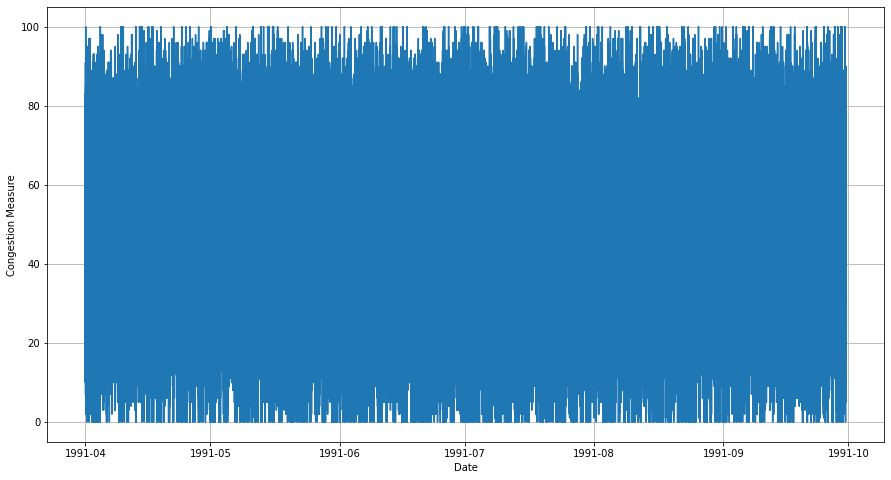

In [11]:
## Creating a new figure
plt.figure(figsize = (15, 8))

plt.plot(train['time'], train['congestion'])
plt.xlabel('Date')
plt.ylabel('Congestion Measure')
plt.grid()
plt.show()

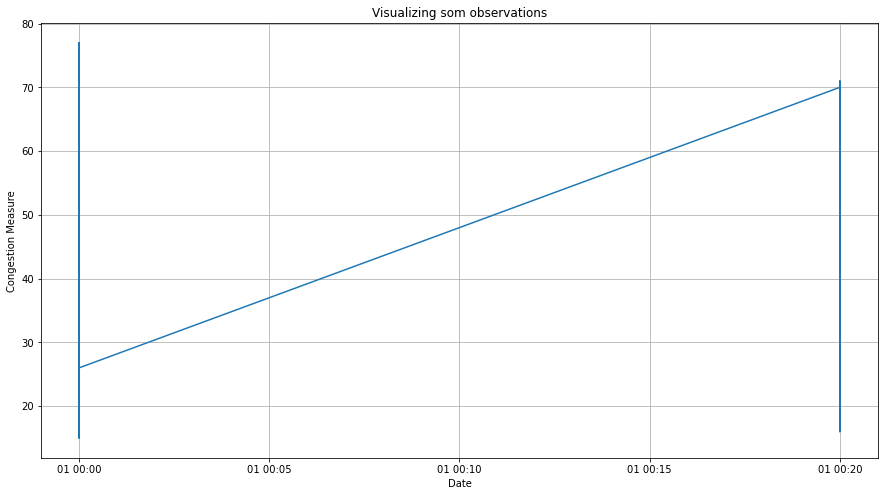

In [14]:
## Creating a new figure
plt.figure(figsize = (15, 8))

plt.plot(train['time'][0:100], train['congestion'][0:100])
plt.xlabel('Date')
plt.ylabel('Congestion Measure')
plt.title('Visualizing som observations')
plt.grid()
plt.show()

In [23]:
out = train[(train['direction'] == 'EB') & (train['x'] == 0) & (train['y'] == 0)]
out.head(10)

,row_id,time,x,y,direction,congestion,day,hour,minute,EB,NB,NE,NW,SB,SE,SW,WB
0,0,1991-04-01 00:00:00,0,0,EB,70,0,0,0,1,0,0,0,0,0,0,0
65,65,1991-04-01 00:20:00,0,0,EB,70,0,0,20,1,0,0,0,0,0,0,0
130,130,1991-04-01 00:40:00,0,0,EB,70,0,0,40,1,0,0,0,0,0,0,0
195,195,1991-04-01 01:00:00,0,0,EB,70,0,1,0,1,0,0,0,0,0,0,0
260,260,1991-04-01 01:20:00,0,0,EB,70,0,1,20,1,0,0,0,0,0,0,0
325,325,1991-04-01 01:40:00,0,0,EB,70,0,1,40,1,0,0,0,0,0,0,0
390,390,1991-04-01 02:00:00,0,0,EB,70,0,2,0,1,0,0,0,0,0,0,0
455,455,1991-04-01 02:20:00,0,0,EB,70,0,2,20,1,0,0,0,0,0,0,0
520,520,1991-04-01 02:40:00,0,0,EB,70,0,2,40,1,0,0,0,0,0,0,0
585,585,1991-04-01 03:00:00,0,0,EB,70,0,3,0,1,0,0,0,0,0,0,0


In [26]:
out.shape

(13059, 17)

In [27]:
out_test = test[(test['direction'] == 'EB') & (test['x'] == 0) & (train['y'] == 0)]
out_test.head(10)

,row_id,time,x,y,direction,day,hour,minute,EB,NB,NE,NW,SB,SE,SW,WB
0,848835.0,1991-09-30 12:00:00,0.0,0.0,EB,0.0,12.0,0.0,1,0,0,0,0,0,0,0
65,848900.0,1991-09-30 12:20:00,0.0,0.0,EB,0.0,12.0,20.0,1,0,0,0,0,0,0,0
130,848965.0,1991-09-30 12:40:00,0.0,0.0,EB,0.0,12.0,40.0,1,0,0,0,0,0,0,0
195,849030.0,1991-09-30 13:00:00,0.0,0.0,EB,0.0,13.0,0.0,1,0,0,0,0,0,0,0
260,849095.0,1991-09-30 13:20:00,0.0,0.0,EB,0.0,13.0,20.0,1,0,0,0,0,0,0,0
325,849160.0,1991-09-30 13:40:00,0.0,0.0,EB,0.0,13.0,40.0,1,0,0,0,0,0,0,0
390,849225.0,1991-09-30 14:00:00,0.0,0.0,EB,0.0,14.0,0.0,1,0,0,0,0,0,0,0
455,849290.0,1991-09-30 14:20:00,0.0,0.0,EB,0.0,14.0,20.0,1,0,0,0,0,0,0,0
520,849355.0,1991-09-30 14:40:00,0.0,0.0,EB,0.0,14.0,40.0,1,0,0,0,0,0,0,0
585,849420.0,1991-09-30 15:00:00,0.0,0.0,EB,0.0,15.0,0.0,1,0,0,0,0,0,0,0


In [28]:
out_test.shape

(36, 16)

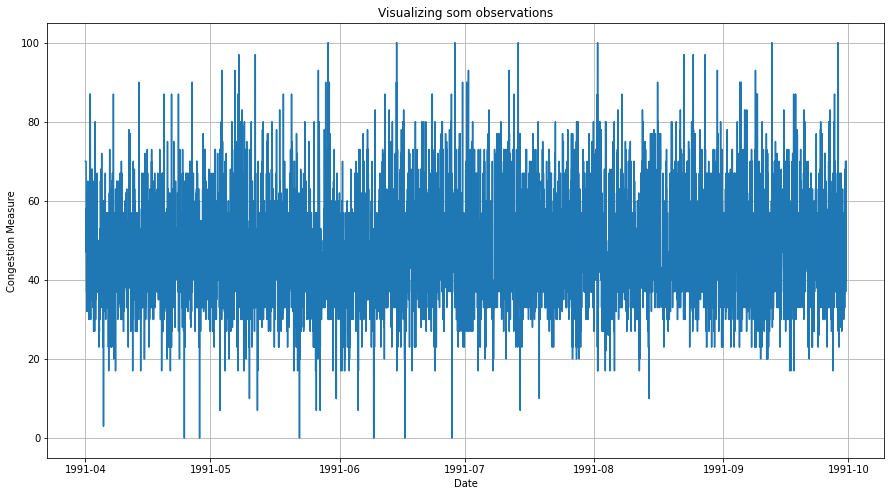

In [25]:
## Creating a new figure
plt.figure(figsize = (15, 8))

plt.plot(out['time'], out['congestion'])
plt.xlabel('Date')
plt.ylabel('Congestion Measure')
plt.title('Visualizing som observations')
plt.grid()
plt.show()

## Modeling 

In [13]:
train_data_sample = train[(train['direction'] == 'EB') & (train['x'] == 0) & (train['y'] == 0)].reset_index(drop = True)
test_data_sample = test[(test['direction'] == 'EB') & (test['x'] == 0) & (test['y'] == 0)].reset_index(drop = True)

In [14]:
## Splitting the data intro train & valudation 
X_train = train_data_sample.loc[0:13023, ['day', 'hour', 'minute']].reset_index(drop = True)
Y_train = train_data_sample.loc[0:13023, ['congestion']].reset_index(drop = True)

X_val = train_data_sample.loc[13023:13059, ['day', 'hour', 'minute']].reset_index(drop = True)
Y_val = train_data_sample.loc[13023:13059, ['congestion']].reset_index(drop = True)

In [26]:
## Buidling XGBoost
xgb = XGBRegressor(booster = 'gbtree', objective = 'reg:squarederror', n_estimators = 500, max_depth = 10, learning_rate = 0.01, n_jobs = -1).fit(X_train, Y_train)

## Predicting on the test 
xgb_pred = xgb.predict(X_val)

## Computing the mse
print(mean_squared_error(Y_val, xgb_pred))

171.7673960442266


In [27]:
xgb_pred

array([39.317127, 39.52224 , 39.479378, 39.508648, 39.508648, 47.895203,
       54.551197, 54.64076 , 54.19031 , 54.422962, 54.483276, 53.802757,
       53.59253 , 52.796688, 47.99042 , 54.127586, 46.685932, 46.26107 ,
       53.28638 , 45.7671  , 47.461582, 42.703625, 45.377266, 45.724842,
       49.494698, 44.978592, 46.385483, 49.257893, 48.46913 , 51.319477,
       48.65144 , 49.71928 , 54.249405, 47.27552 , 48.364655, 54.41104 ],
      dtype=float32)

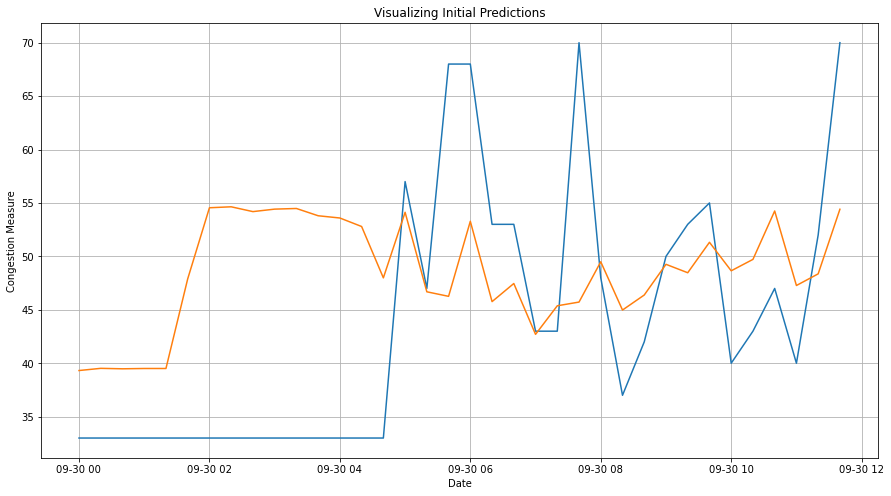

In [28]:
## Creating a new figure
plt.figure(figsize = (15, 8))

plt.plot(train_data_sample['time'][13023:13059], train_data_sample['congestion'][13023:13059])
plt.plot(train_data_sample['time'][13023:13059], xgb_pred)
plt.xlabel('Date')
plt.ylabel('Congestion Measure')
plt.title('Visualizing Initial Predictions')
plt.grid()
plt.show()